# Model assessment basics

In [109]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

pd.options.display.float_format = '{:,.3f}'.format

## Training set metric on random data

In [110]:
X_train = np.random.random((1000,4))
y_train = np.random.random(1000)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.8444686876821665

## NYC rent testing

In [111]:
df_rent = pd.read_json("data/rent-train.json")
features = ['bedrooms', 'bathrooms', 'latitude', 'longitude']
df_rent = df_rent[features+['price']]
X = df_rent.drop('price', axis=1)
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
10,3,1.500,40.715,-73.942
10000,2,1.000,40.795,-73.967
100004,1,1.000,40.739,-74.002
100007,1,1.000,40.754,-73.968
100013,4,1.000,40.824,-73.949


**Break out 20% hold out validation set**

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Train model, compute metrics**

In [113]:
def test():
    rf = RandomForestRegressor(n_estimators=50, oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train)
    oob = rf.oob_score_ # wow this is a terrible score
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (oob,r2,mae,mse)
    df_metrics = pd.DataFrame([[oob,r2,mae,mse]],
                              columns=['OOB', 'R^2', 'MAE', 'MSE'])
    print(df_metrics)
#    print(f"{oob:4.2f}, {r2:5.2f}, {mae:5.2f}, {mse:.2f}")

**This error is stable; just variation due to RF**

In [114]:
pd.DataFrame([test() for i in range(3)], columns=['OOB', 'R^2', 'MAE', 'MSE'])

,OOB,R^2,MAE,MSE
0,-0.025,-16.404,501.968,"141,205,870.999"
1,-0.140,-31.987,551.890,"267,640,604.980"
2,-0.043,-32.016,553.197,"267,877,685.213"


**Very unstable if we pick more valid sets**

In [115]:
results = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    results.append( test() )
df_results = pd.DataFrame(results, columns=['OOB', 'R^2', 'MAE', 'MSE'])
df_results

,OOB,R^2,MAE,MSE
0,-0.338,-1.358,768.099,"558,629,194.713"
1,-0.412,-64.382,590.618,"433,053,510.374"
2,-0.095,0.648,370.715,"1,955,268.612"
3,0.050,0.045,882.621,"2,062,699,730.667"
4,-0.120,0.810,444.062,"22,855,306.229"


In [116]:
df_results.std()

OOB             0.189
R^2            28.821
MAE           214.755
MSE   845,365,655.755
dtype: float64

**Try k-fold**

In [117]:
k = 5
kf = KFold(n_splits=k, shuffle=True)
results = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    results.append( test() )
df_results_kfold = pd.DataFrame(results, columns=['OOB', 'R^2', 'MAE', 'MSE'])
df_results_kfold

,OOB,R^2,MAE,MSE
0,-0.182,0.861,439.852,"17,024,133.725"
1,-0.257,-1.411,752.574,"615,192,818.662"
2,0.521,0.002,840.718,"2,040,429,004.345"
3,-0.166,-55.326,616.396,"367,222,245.838"
4,-0.024,0.669,384.038,"1,946,337.328"


In [118]:
df_results_kfold.std() # still unstable; try running it multiple times

OOB             0.315
R^2            24.772
MAE           195.930
MSE   840,599,692.790
dtype: float64

In [119]:
k = 5
cvscore = cross_val_score(
			RandomForestRegressor(n_estimators=50), # which model to use
			X_train, y_train, # what training data to split up
			cv=k, # number of folds/chunks
			scoring='neg_mean_absolute_error') # what error metric
-cvscore

array([689.63026587, 991.53300531, 402.87912948, 819.31854029,
       430.16370886])

## Classifiers

In [120]:
from sklearn.metrics import confusion_matrix

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier(n_estimators=30, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

C = confusion_matrix(y_test, y_pred)
C

array([[36,  5],
       [ 3, 70]])

In [121]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
tn, fp, fn, tp

(36, 5, 3, 70)

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        41
           1       0.93      0.96      0.95        73

   micro avg       0.93      0.93      0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



## R^2

Text(0.5, 1.0, '$R^2$ = 0.991')

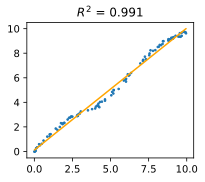

In [168]:
n = 100
x = np.random.random(size=n)*10
y = x + np.sin(x)*.45 + np.random.normal(size=n)*.1
plt.figure(figsize=(3,2.5))
plt.scatter(x,y,s=3)

lm = LinearRegression()
lm.fit(x.reshape(-1,1), y)
y_pred = lm.predict(x.reshape(-1,1))
plt.plot(x, y_pred, c='orange')
plt.title(f"$R^2$ = {lm.score(x.reshape(-1,1),y):.3f}", fontsize=12)

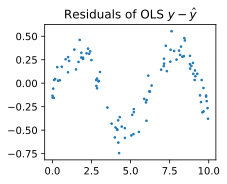

In [172]:
plt.figure(figsize=(3.08,2.5))
plt.scatter(x, y-y_pred, s=3)
plt.title("Residuals of OLS $y - \hat{y}$")
plt.show()

In [194]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)
df

,x,y
0,0.000,-1.227
1,1.111,0.835
2,2.222,2.034
3,3.333,4.751
4,4.444,3.818
5,5.556,4.323
6,6.667,9.511
7,7.778,7.823
8,8.889,10.303
9,10.000,10.522


In [195]:
X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)

0.9216315643072138

Text(0.5, 1.0, 'MAE 0.87, MSE 1.20')

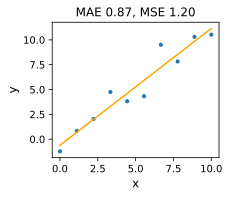

In [196]:
plt.figure(figsize=(3,2.5))
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f}")
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

In [197]:
y.iloc[-1] = 100

Text(0, 0.5, 'y')

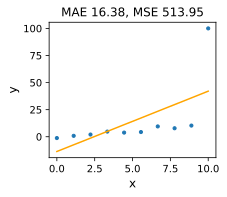

In [200]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f}")

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

Text(0, 0.5, 'y')

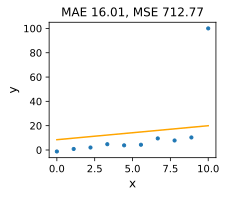

In [201]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = Lasso(alpha=45)
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f}")

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)